# MLiM 25440 Homework 6
### Brendan Sanderson

##### Imports and set up

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import itertools
import collections
from sklearn.manifold import TSNE
import re
import time

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Embedding, Concatenate, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout
from sklearn.model_selection import KFold, train_test_split
from keras.utils import to_categorical

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##### Data Setup

I chose not to use a data generator as I was able to load the dataset into google collab without an issue.

In [0]:
abstracts_sentences = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW6/labeled_abstracts_reduced_80000.csv", sep=';', 
    header=None, names=["Subject", "Abstract"])

In [0]:
abstracts = []
for s in abstracts_sentences["Abstract"]:
  abstracts.append(s.lower().split())
subjects = np.array(abstracts_sentences["Subject"])

In [0]:
subject_mapping = {x: i for i,x in enumerate(list(set(subjects)))}
subjects_int = [subject_mapping[word] for word in subjects]

#### Helper Functions

In [0]:
# Timer helper class for timing methods.
class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, elapsed):
        self.elapsed = elapsed
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        tim =  time.time() - self.t
        self.elapsed.append(tim)

## Building embedding models for text [30 points]


#### Construct an embedding matrix that stores a length 512 vector for each word in the vocabulary based on the Word2Vec model. Save your embedding matrix (numpy matrix is recommended) so that you can use it subsequently. Be sure to also construct a dictionary that correctly maps each word to the appropriate row in your embedding matrix so we know what each row represents. Note that the 0th row in your embedding matrix should not be used for any words and be set to all zeros because 0 is reserved for padding! [10 points]

In [0]:
def embedding_model(abstracts, embedding_size):
  model = Word2Vec(size=embedding_size, window=8,
                    min_count=2, workers=4, alpha=0.025, min_alpha=0.025)
  model.build_vocab(abstracts) #where abstracts contains the content of the abstracts
  # train on the abstracts
  for epoch in range(10): 
    model.train(abstracts,total_examples=model.corpus_count,epochs=1) 
    model.alpha -= 0.002 #decrease the learning rate
    model.min_alpha = model.alpha #fix the learning rate, no decay
    model.init_sims(replace=True)
  # iterate through the learned vocabulary from the word2vec model
  # for key,val in model.wv.vocab.items():
    # print(key) #this is the word
    # print(model[key]) #this is the word2vec vector
  return model


In [0]:
embedding_size = 512
model = embedding_model(abstracts, embedding_size)

In [0]:
embedding_size = 512
#Create the embedding matrix with zeroes in the first row
embedding_matrix = [np.zeros(embedding_size)]
#Create the embedding mapper
embedding_mapper = {0:0}
for i,key in enumerate(model.wv.vocab.keys()):
  #For each word, add it to the matter and the the matrix
  embedding_mapper[key] = i+1 
  embedding_matrix.append(model[key])

embedding_matrix = np.array(embedding_matrix)

#### Next, you are going to process each abstract such that each word is replaced by its corresponding row number in the embedding matrix. A common practice for text is to clip/pad all documents to the same length. For this exercise, all abstracts longer than 250 words should be clipped to 250 words, and all abstracts shorter than 250 words should be padded with 0’s to be 250 words. Save these processed abstracts as numpy arrays – these will be the inputs to the deep learning classifier. Be sure not to lose the corresponding label associated with each abstract! [10 points]

I will save the row number for each embedding in `abstract_embeddings`.

In [0]:
vocab = set(embedding_mapper.keys())
abstract_embeddings = np.empty((len(abstracts), 250))
for i,a in enumerate(abstracts):
  a_trim = []
  #Remove all words that appear only once and are not in the embedding matrix
  for w in a:
    if w in vocab:
      a_trim.append(w)
  #if the lengtn is greater than 250, take the first 250
  if len(a_trim) >= 250:
      for j,w in enumerate(a_trim[:250]):
        abstract_embeddings[i,j] = embedding_mapper[w]
  #If the length is less than 250, take all of the words and then pad the rest with 0's
  else:
    for j,w in enumerate(a_trim):
        abstract_embeddings[i,j] = embedding_mapper[w]
    for j in range(len(a_trim),250):
      abstract_embeddings[i,j] = 0

In [0]:
np.save('/content/drive/My Drive/HW6/em', embedding_matrix)
np.save('/content/drive/My Drive/HW6/ae', abstract_embeddings)
np.save('/content/drive/My Drive/HW6/subs', subjects_int)

#### Finally, it will be interesting to see if your embedding model really works. For this, we are going to extract the most common 500 words (this is to make sure you don’t have to do it on a large vocabulary) and use t-stochastic neighborhood embedding (t-SNE) to visualize this in 2D. Obviously we can’t visualize a 300 dimensional space, so we will train the TSNE model to accept the embeddings and plot a 2D plot to show us how the words are organized. [10 points]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


plotting most common words


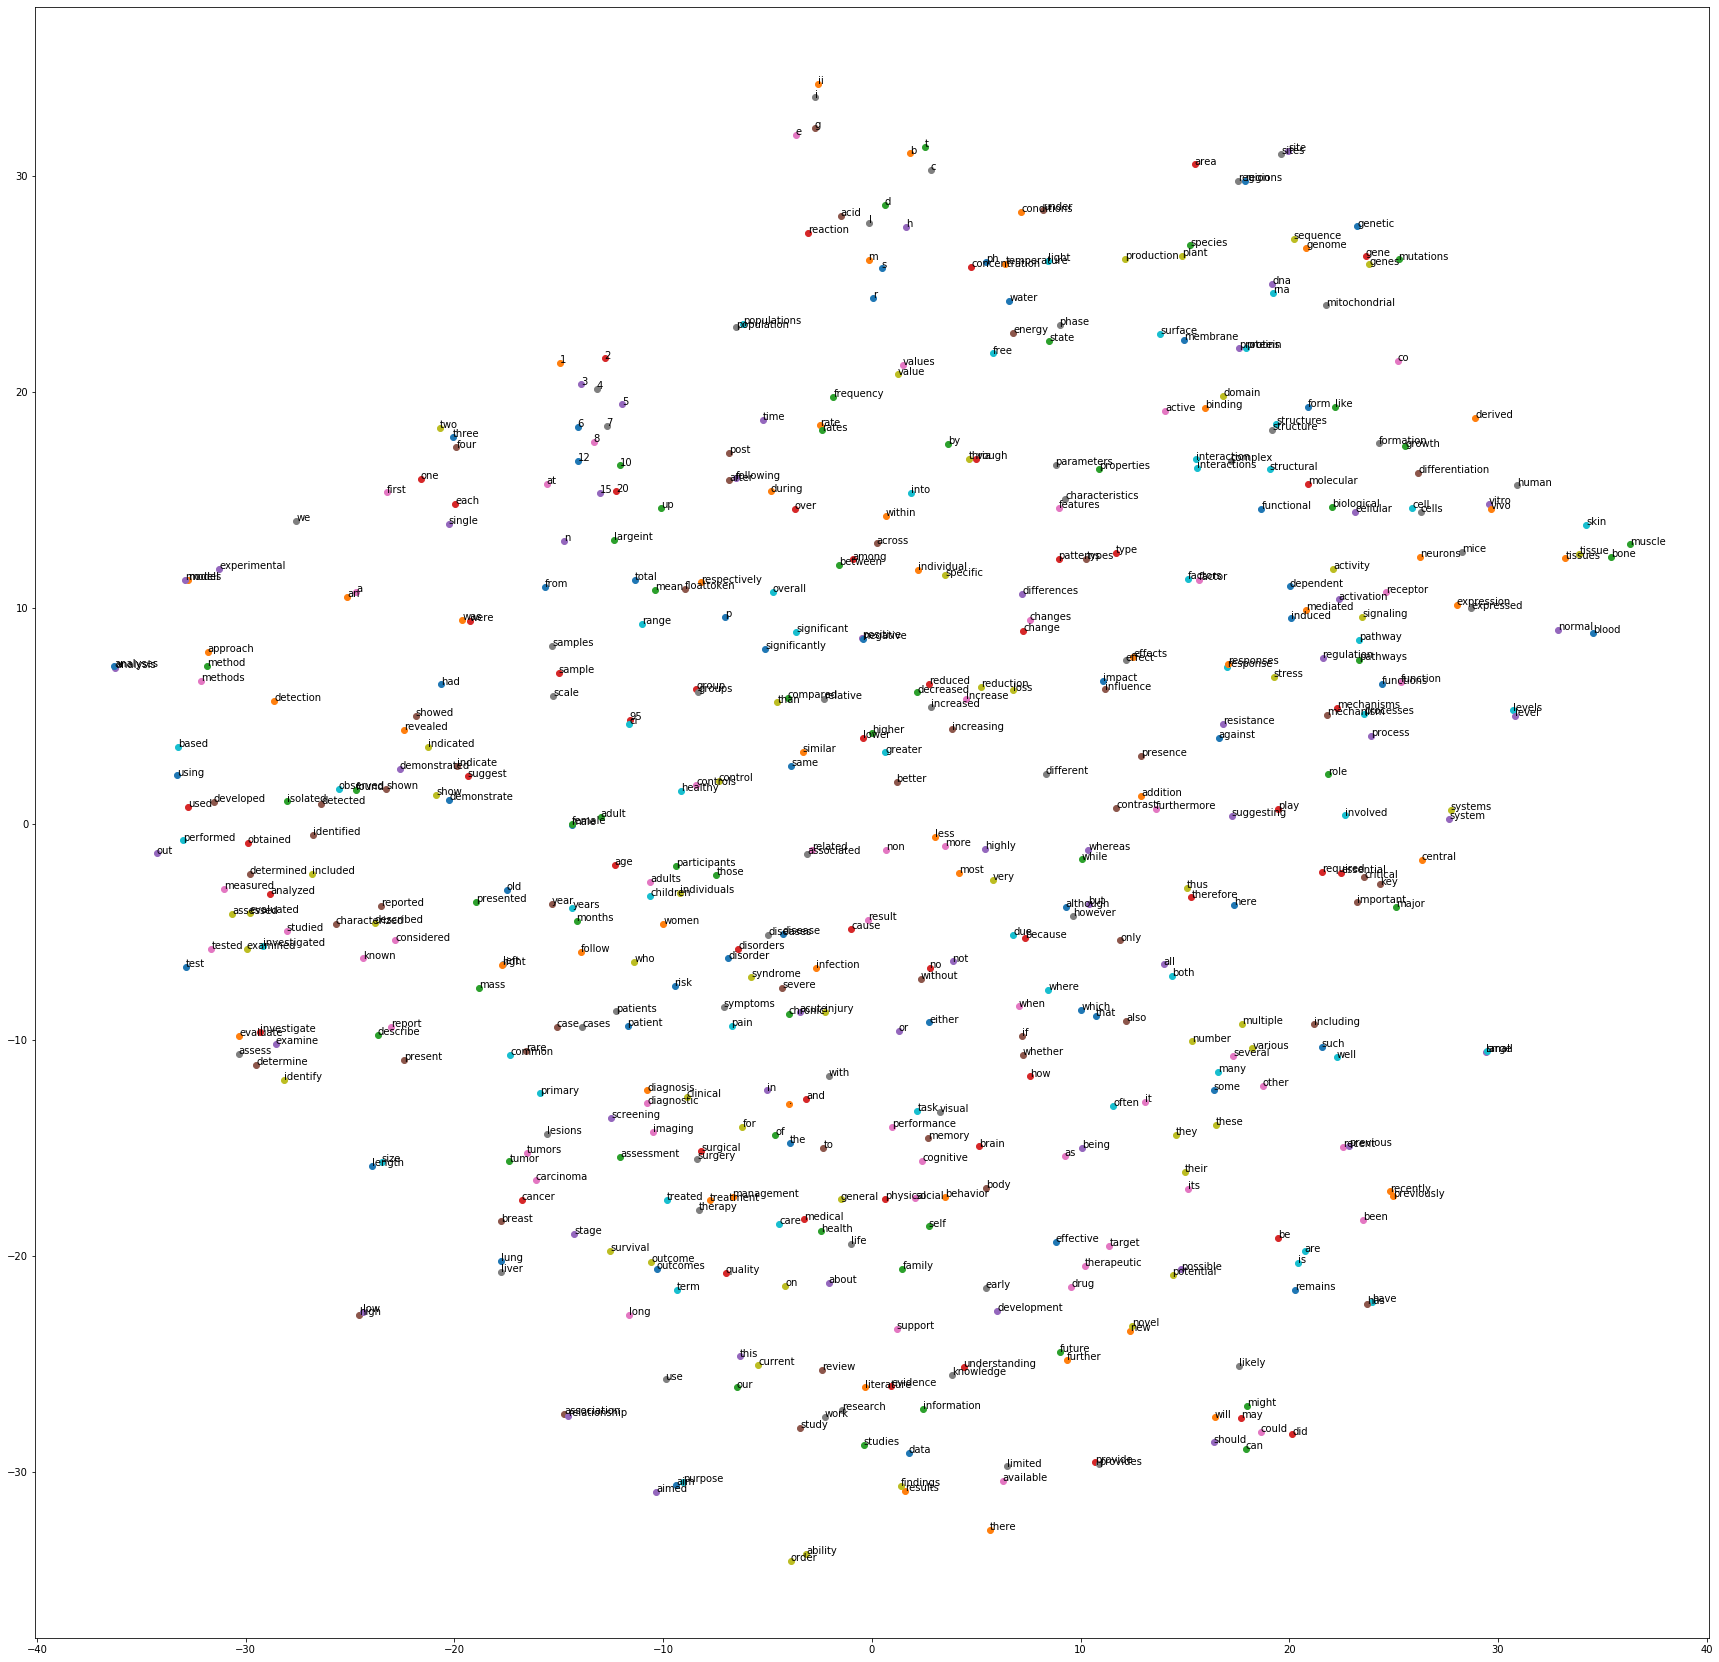

In [0]:
allwords = [w for ws in abstracts for w in ws]
counts = collections.Counter(allwords).most_common(500)
embeddings = np.empty((500,embedding_size)) 
for i in range(500):
  embeddings[i,:] = model[counts[i][0]]
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=7500) 
embeddings = tsne.fit_transform(embeddings)
#plot embeddings
print("plotting most common words")
fig, ax = plt.subplots(figsize=(30, 30))
for i in range(500):
  ax.scatter(embeddings[i,0],embeddings[i,1])
  ax.annotate(counts[i][0], (embeddings[i,0],embeddings[i,1]))

## Building a simple CNN to classify abstracts [35 points]
Now that you have your data dictionary and you can easily construct the word embeddings, we can build some deep learning models. First, we’ll need to split the data into train and test sets. Use the `sklearn.model_selection.train_test_split` function from the Python scikitlearn package to split 80% of the abstracts (and corresponding labels) into a train set and the rest into your test set.
Now, let’s build a simple convolutional neural network (CNN). Your CNN should have the following:
  
* An input layer which takes in a batch of documents [n x 250], where each word in a document is represented by its corresponding row (integer) in the embedding matrix
* An embedding lookup layer that replaces each word index with its corresponding word embedding vector in your embedding matrix [n x 250 x 300]
* Three parallel 1D convolution layers:
A 1D convolution with a window size of 3 words and 100 filters [n x 250 x 100] A 1D convolution with a window size of 4 words and 100 filters [n x 250 x 100] A 1D convolution with a window size of 5 words and 100 filters [n x 250 x 100]
* A layer that concatenates the output of the three parallel 1D convolution layers [n x 250 x 300]
* A temporal maxpool layer that, for each filter, selects the max value across all words for that filter [n
x 300]
* A softmax layer that outputs the class probabilities for each document [n x 8]
* For training, use cross entropy loss with the Adam optimizer

#### Helper Functions and Loading Data from saves If Needed

In [0]:
embedding_matrix = np.load('/content/drive/My Drive/HW6/em.npy')
X = np.load('/content/drive/My Drive/HW6/ae.npy')
y = np.load('/content/drive/My Drive/HW6/subs.npy')

The function definitions for 5 fold error rate testing and for calculating and plotting the learning curve.

In [0]:
def five_fold_network_test(model, X, y, eps, sp = 5):
  errs = []
  ns = 5
  tim = []
  kf = KFold(n_splits=ns)
  unique_labels = np.unique(y)
  model.save_weights('empty')
  print('\r', 'Splits Done: 0 / 5', end='')
  for i, (train_index, test_index) in enumerate(list(kf.split(X))[:sp]):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = to_categorical(y, num_classes=8)[train_index], y[test_index]
      with Timer(tim):
        model.fit(x=X_train, y=y_train, epochs=eps, batch_size=256, shuffle=True)
      y_prob = model.predict(X_test) 
      y_hat = y_prob.argmax(axis=-1)
      errs.append(np.mean(y_hat != y_test))
      model.load_weights('empty')
      print('\r','Splits Done:', i+1,'/ 5', end='')
            
  return (np.mean(errs), np.mean(tim))

def plot_learning_curve(model,X,y, eps = 20):
  X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(y), test_size=0.2)
  hist = model.fit(x=X_train, y=y_train, epochs=eps, batch_size=256, shuffle=True, validation_data=(X_test, y_test), verbose = 0)
  train_error = [1 - a  for a in hist.history['acc']]
  test_error = [1 - a  for a in hist.history['val_acc']]
  plt.figure(figsize = (8,5))
  plt.plot(range(20), train_error, label = "Training Error")
  plt.plot(range(1,21), test_error, label = "Testing Error")
  plt.ylabel("Error Rate")
  plt.xlabel("Epochs")
  plt.title("Learning Curve")
  plt.legend()
  plt.plot()
  return train_error,test_error

#### Your goal for this part of the assignment is to evaluate the training and testing of the model. [30 points]

In [0]:
# The function definiteion for the CNN model. I added a couple of dropout layers before and after the parallel CNN layers.
def embedding_cnn_model():
  input_layer = Input(shape=(250,))
  #First the embedding layer
  embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                      weights=[embedding_matrix], trainable=False)(input_layer)
  #Next, the dropout layer
  dropout1_layer = Dropout(rate=0.2)(embedding_layer)
  #Define the 3 convolutional layers
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same')(dropout1_layer)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same')(dropout1_layer)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same')(dropout1_layer)
  #Concatenate the layers
  merge_layer = Concatenate()([conv1,conv2,conv3])
  #Add another dropout layer
  dropout2_layer = Dropout(rate=0.2)(merge_layer)
  #Max pool layer that takes the max for each word
  maxpool_layer = MaxPooling1D(250)(dropout2_layer)
  #Flatten it, so it it changes from a 250 x 1 matrix , to a 250 vector.
  flatten_layer = Flatten()(maxpool_layer)
  #Finally, the output layer with one weight for each class.
  output_layer = Dense(8, activation='softmax')(flatten_layer)
  model = Model(input_layer, output_layer)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

First, I will compute the learning curve.

[]

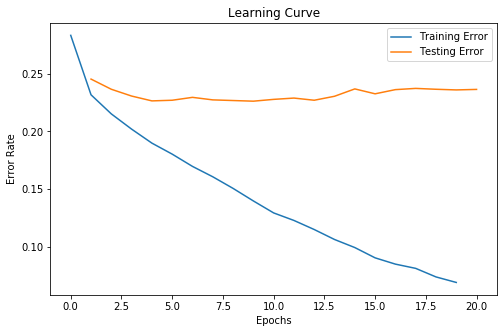

In [0]:
model = embedding_cnn_model()
train_error, test_error = plot_learning_curve(model, X, y, eps = 20)

From looking at the learning curve, the testing error converge to its minimum after 5 epochs.

Next, I will run 5-fold to compute the average testing error.

In [0]:
model = embedding_cnn_model()
acc, runtime = five_fold_network_test(model, X, y, 5)

In [0]:
print("The average testing error rate was:", acc)
print("The average epoch runtime was:", runtime/10, seconds)

The average testing error rate was: 0.22479166666666664
The average epoch runtime was: 56.993147468566896 seconds


#### Comment on what you think happens with the learning. Let’s say, we remove one of the layers in the 1D convolution (say, for e.g., we remove a window size of 5), how does it affect the overall training? [5 points]

If we remove one of the the 1D convolution layer with a window size of 5, then we would expect the error rate to increase slightly, but the model to train and converge much faster. If we remove this layer, then the model will no longer examine sequences of 5 words. This means that if for instance there is specific phrase of 5 words that appears in a lot of abstracts corresponding to a particular subject, then the model will not be able to determine that this 5 word phrase corresponds to that class. Thus, I would expect the error rate to be increase as the model is not capable of detecting 5 word phrases. However, the model would still examine 4 word phrases and thus it would see this 5 world phrase as 2 4-word phrases, implying that it would still make some connection between that prhase and the class. Thus, I would not expect the error rate to increase significantly much due to this. In addition, the model would overall have less features as we are completely removing a layer. This also likely would slightly increase the error rate. However, as there are less features, training time would be shorter and convergence would be obtained faster as the network is less complex, implying that the optimal set of weights is easier to determine. Thus, the error rate would increase, but likely not too significantly while the runtime and required epochs to converge would likely decrease.

## A simple RNN to classify abstracts [35 points]

#### Based on what we did with the CNN, use the same embedding layers, but instead of the three parallel 1D convolution layers, replace them with a single bi-directional LSTM (bi-LSTM) that spans an entire sentence. Feed the Bi-LSTM outputs to a maxpool layer that selects the maximum value across all the words. Finally, connect it to a softmax layer that outputs the class probabilities for each document. For training, use cross- entropy with the Adam optimizer. Your goal for this part of the HW is to evaluate the training/ testing of the RNN model. For this part of the assignment, there is much more flexibility in how you build your RNN classifier – you can follow a canned tutorial example or try your own. The main idea is that we want you to think a bit about how you will design a network – while deriving from an existing one. Many applications are usually designed in this manner. [20 points]

In [0]:
#The function definiteion for the RNN model. I added a couple of dropout layers to this model as well before and after the LSTM.
def embedding_rnn_model():
  input_layer = Input(shape=(250,))
  #First, the embedding layer
  embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                      weights=[embedding_matrix], trainable=False)(input_layer)
  #Next, the first dropout layer
  dropout1_layer = Dropout(rate=0.2)(embedding_layer)
  #The LTSM layer
  ltsm_layer = Bidirectional(LSTM(250, return_sequences = True), merge_mode='ave')(dropout1_layer)
  #Max pool layer that takes the max for each word
  maxpool_layer = MaxPooling1D(250)(ltsm_layer)
  #Dropout layer #2
  dropout2_layer = Dropout(rate=0.2)(maxpool_layer)
  #Flatten it, so it it changes from a 250 x 1 matrix , to a 250 vector.
  flatten_layer = Flatten()(dropout2_layer)
  #Finally, the output layer with a weight for each class
  output_layer = Dense(8, activation='softmax')(flatten_layer)
  model = Model(input_layer, output_layer)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

First, I will compute the learning curve.

[]

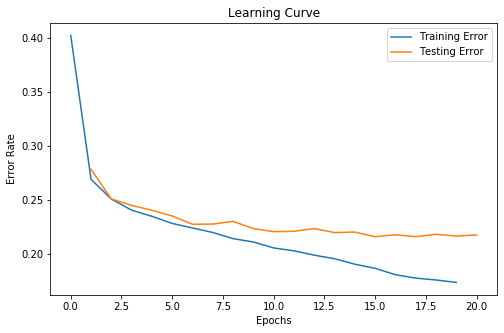

In [0]:
model = embedding_cnn_model()
train_error, test_error = plot_learning_curve(model, X, y, eps = 20)

From looking at the learning curve, the testing error converge to its minimum after 15 epochs.

Next, I will run 5-fold to compute the average testing error.

In [0]:
model = embedding_rnn_model()
acc, runtime = five_fold_network_test(model, X, y, 15)

In [0]:
print("The average testing error rate was:", acc)
print("The average epoch runtime was:", runtime/10, "seconds")

The average testing error rate was: 0.2131875
The average epoch runtime was: 323.6842105263158 seconds


#### How long does it take for your code to run a single epoch of training using the CNN vs. the RNN model? You can do this by reporting the time on the keras prompt for each epoch. [5 points]

The CNN took about 57 seconds an epoch where the LSTM took about 323 seconds an epoch. This is an extremely significant difference. However, it makes sense as the LSTM has more complex calculations to make given that it maintains a state that is a function of all adjacent inputs and the previous layer. In addition, the LSTM has about 1.5 million parameters to train where the CNN has only about 600,000, so the LSTM has 2.5 times more weights to train, which obviously will also increase training time. Finally, we use a bidirectional LSTM, which runs the LSTM in both directions, which should double the expected run time. When taking these factors into account, it makes sense that the runtime for the RNN network is so much longer.

#### What are the number of epochs required to train each of these networks to achieve a convergence? Can you comment on the differences between the training for RNN and the CNN? [5 points]

Looking at the learning curves above, both models perform extremely well at 1 epoch. However, the CNN network converges to its minimum faster after 5 epochs while the RNN network doesn't converge to its minimum for 15 epochs. However, the RNN converges to a lower value. This is interesting as they both train very well. After 1 epoch, the weights are already fairly close to their minimum. However, it clearly shows that an LSTM is more difficult to train as it takes far longer to achieve its minimum. This makes sense given the structure of an LSTM as the LSTM weights are a function of the adjacent weights in addition to the previous layer. As previously mentioned, the LSTM has about 1.5 million parameters to train where the CNN has only about 600,000. Having more weights means that it will take more epochs for all of the weights to reach the overall optimal values. Thus, it makes sense that the LSTM will take longer to converge, but the LSTM is able to converge to a lower value.

#### Can you comment on whether a simple classifier such as an SVM (or any other classifier of your choice) works equally well with respect to the two classifiers you built? [5 points]

As shown in class lecture, classical classifiers will not work equally with with respect to the two classifiers I built. This is because when it comes to NLP, the sequences of words are the most significant indicator of the meaning while individual words do not indicate that much on their own. Both classifiers we looked at in this lab look at sequences of words and assume that their position has a significant meaning. Thus, they are able to make connections about the implication of groups of words. Classifical classifiers look primary on individual values and do not assume that adjacent values do not have any sort of meaning. Thus, they would not be able to make the same connections about sequences of words and therefore wouldn't perform as well.


## Write Up

In the first part of this exercise, I looked at embeddings of words based on abstracts. I was amazed by how effective `word2vec` is at mathematically comparing words. The embeddings plot amazing groups together words that are definitely very similar to each other. For instance, "investigate", "determine", "examine", "assess", "identify" and "evaluate" are all super close together. These words also have meanings and uses cases that are very similar and almost interchangeable. Thus, it makes a lot of sense that they are grouped together.

In the second and third part, I looked at how effective a 1-dimensional CNN and an RNN with a LSTM layer are at evaluating word embeddings. First off, I thought using an embedding layer was an extremely useful technique to drastically lower the size of the input data. If I had directly put the embeddings into my input matrix, my input would be 80000 x 250 x 512 of float values, which would have been over 80 gigabytes. By having an embedding layer, we lower the input size to only 80000 x 250 of int values, which is less than a fifth of a gigabyte and extremely manageable for any machine. 

Comparing assessing the power of the CNN versus the RNN was extremely interesting. They both preform similarly and assess adjacent sequences of words instead of each word individually, but they do so in different ways. The CNN looks at a group of words (3,4 and 5) in this case and assigns a weight to that group. The RNN computes a weight for each value, but that weight is a function of the inputs encountered before that value. They both do an effective job of this, but there is definitely a tradeoff between the two. The RNN gave us an error rate that was just over 1% better, which is not that small, but any increases in accuracy are extremely useful. However, each epoch in the RNN took over 5 times longer than the CNN. Also, the RNN took 3 times longer to converge. However, it is important to note that the RNN outperformed the CNN after 5 epochs, it just a long time for the RNN to gain that extra 1% accuracy. Thus, it is not necessarily fair to say that the RNN takes more epochs to train. It just takes longer to reach its minimum. It is important to note though that as accuracy gets better, each marginal increase in accuracy is extremely more costly. This is evidently from the fact that the RNN and CNN are about equal in accuracy after 5 epochs and it takes the RNN 10 more epochs to converge and gain just over 1.1% more accuracy. Overall, this makes the RNN appear the be the more accurate model, but a way more expensive way. The CNN feels like a budget version of the RNN, but it is an extremely effective one as the runtimes of the RNN are so much longer.

In the world of medicine, any amount of additional accuracy is extremely important. Thus, I would say to use the RNN, especially if training a model that will be used for a while in the future because if its slightly better accuracy. However, the CNN is definitely an amazing way to estimate how powerful a dataset or if you want to make a quick temporary model is without having to wait for such long training times. Thus, they are both extremely valuable in different cases as the RNN has better accuracy, but extremely computationally expensive and the CNN is only sightly worse and way faster.
